# 利用 TF-idf 、 LDA 、LSA 对 中文文本进行 特征提取

## 加载库

In [42]:
import os
from gensim import corpora, models, similarities
from pprint import pprint
from matplotlib import pyplot as plt
import logging
from gensim import corpora
from collections import defaultdict
import numpy as np 
import jieba
jieba.load_userdict("../../data/dict.txt")
from gensim.models import CoherenceModel
np.random.seed(1) # 设置随即种子数，以便相同的设置能跑出相同的结果，可复现


## 变量设置

In [43]:
doc_path = "THUCNews/1.txt"
# doc_path = "../../data/classification/THUCnews/train.txt"
documents = [line.strip().split("\t")[0] for line in open(doc_path,encoding="utf-8").readlines() ]
documents = documents[0:1000]
len(documents),documents[0:2]

(120,
 ['中国大陆方面，股市迎来一波猛涨，站上五年来的最高点。本周，因新冠疫情延期一月的中国高考拉开帷幕，但高考前多起包括冒名顶替在内的舞弊案件引发对公平性的讨论。北京新一轮疫情得到控制，本周首现零新增。同样在北京，知名法学家许章润被警察带走，最近几年他发表多篇文章批评中国当局。',
  '香港《国安法》在香港和海外持续发酵。本周BBC中文通过五张图为你详解其中的法律重点，比如相关机构组成和权力分配等。西方国家对香港《国安法》反应强烈，此前英国承诺为香港BNO护照持有者开启移民入籍路径，本周BBC中文采访探讨这一政策是否会导致香港移民潮。本周澳大利亚政府也推出一系列措施，作为回应，包括暂停与香港的引渡协议、更新旅游建议以及为香港居民提供签证便利等。中国则对两国的干涉表示反对，称澳方成天把反对"外国干涉"挂在嘴边，却在涉港问题上说三道四，充分暴露了其虚伪性和双重标准。'])

## 编写函数

In [44]:
def PrintDictionary(dictionary):
    token2id = dictionary.token2id
    dfs = dictionary.dfs
    token_info = {}
    for word in token2id:
        token_info[word] = dict(
            word = word,
            id = token2id[word],
            freq = dfs[token2id[word]]
        )
    token_items = token_info.values()
    token_items = sorted(token_items, key = lambda x:x['id'])
    print('The info of dictionary: ')
    pprint(token_items)
    print('--------------------------')

# 绘图
def Show2dCorpora(corpus):
    nodes = list(corpus)
    ax0 = []
    ax1 = []
    for x in nodes:
#         print(f"x:{x}")
        try:
            ax1.append(x[1][1])
            ax0.append(x[0][1])
        except Exception:
            print(f"x:{x}")
    # print(ax0)
    # print(ax1)
    plt.plot(ax0,ax1,'o')
    plt.show()
    
# step1 : 数据分词处理
def data_process(documents,stop_word_path='../../data/stop_words.txt',freq=0):
    '''
        功能：数据分词处理
        input:
            documents       String List   文档信息 
            stop_word_path  String        停用词 路径 
            frep:           int           频率
        return:  
            texts           String List   分词后的 文本
    '''
    stop_word = [line.strip() for line in open(stop_word_path,encoding="utf-8").readlines() ]
    stoplist = list(set(stop_word))
    stoplist.append(" ")
    texts = [[word for word in list(jieba.cut(document, cut_all=False)) if word not in stoplist]
         for document in documents]
    # 去掉只出现低于 freq 次的单词
    frequency = defaultdict(int)
    for text in texts:
        for token in text:
            frequency[token] += 1
    texts = [[token for token in text if frequency[token] > freq]
             for text in texts]
    return texts

# 功能：加载 词典
def get_dict(texts):
    '''
        功能：加载 词典
        input:
            texts  String List  分词后的 文本 
        ouput:
            dictionary : Dict   词典
    '''
    dictionary = corpora.Dictionary(texts)   # 生成词典 
    # 将文档存入字典，字典有很多功能，比如
    # diction.token2id 存放的是单词-id key-value对
    # diction.dfs 存放的是单词的出现频率
    dictionary.save('output/deerwester_zh.dict')  # store the dictionary, for future reference
    corpus = [dictionary.doc2bow(text) for text in texts]
    corpus = [dictionary.doc2bow(text) for text in texts]
    corpora.MmCorpus.serialize('output/deerwester_zh.mm', corpus)  # store to disk, for later use
    return dictionary

# 功能：利用指标确定 主题数
def evaluate_coherence_values(Model,dictionary, corpus, texts, limit, start=2, step=3, coherence='c_v'):
    """
        Compute c_v or u_mass coherence for various number of topics
        decs:
            通过CoherenceModel这个类中的两个指标 --- U_Mass Coherence和C_V coherence来判定主题模
            型质量的好坏（对文本的主题区分度效果，即能将混沌的语料切分出人类可理解的主题），这两个指标都是
            数值越大，主题模型的效果越好。

        Parameters:
        ----------
            Model: model  lsi_model or lda_model
            dictionary : Gensim dictionary
            corpus : Gensim corpus
            texts : List of input texts
            limit : Max num of topics
            start: start step
            step： step 
            coherence: 评价指标  c_v  or u_mass

        Returns:
        -------
   
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model =Model(corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence=coherence)
        coherence_values.append(coherencemodel.get_coherence())

    x = range(start, limit, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

## 数据预处理

In [45]:
texts = data_process(documents)
dictionary = get_dict(texts)

## 数据加载

In [46]:
if (os.path.exists("output/deerwester_zh.dict")):
    dictionary = corpora.Dictionary.load('output/deerwester_zh.dict')
    corpus = corpora.MmCorpus('output/deerwester_zh.mm')
    print("Used files generated from first tutorial")
else:
    print("Please run first tutorial to generate data set")

PrintDictionary(dictionary)

Used files generated from first tutorial
The info of dictionary: 
[{'freq': 1, 'id': 0, 'word': '一月'},
 {'freq': 1, 'id': 1, 'word': '一波'},
 {'freq': 38, 'id': 2, 'word': '中国'},
 {'freq': 4, 'id': 3, 'word': '五年'},
 {'freq': 2, 'id': 4, 'word': '公平性'},
 {'freq': 2, 'id': 5, 'word': '冒名顶替'},
 {'freq': 3, 'id': 6, 'word': '几年'},
 {'freq': 1, 'id': 7, 'word': '前多起'},
 {'freq': 18, 'id': 8, 'word': '包括'},
 {'freq': 6, 'id': 9, 'word': '北京'},
 {'freq': 3, 'id': 10, 'word': '发表'},
 {'freq': 3, 'id': 11, 'word': '在内'},
 {'freq': 1, 'id': 12, 'word': '多篇'},
 {'freq': 1, 'id': 13, 'word': '大陆'},
 {'freq': 2, 'id': 14, 'word': '带走'},
 {'freq': 2, 'id': 15, 'word': '延期'},
 {'freq': 4, 'id': 16, 'word': '引发'},
 {'freq': 5, 'id': 17, 'word': '当局'},
 {'freq': 3, 'id': 18, 'word': '批评'},
 {'freq': 1, 'id': 19, 'word': '拉开帷幕'},
 {'freq': 4, 'id': 20, 'word': '控制'},
 {'freq': 3, 'id': 21, 'word': '文章'},
 {'freq': 1, 'id': 22, 'word': '新一轮'},
 {'freq': 18, 'id': 23, 'word': '新冠'},
 {'freq': 2, 'id': 24,

limit_output extension: Maximum message size of 10000 exceeded with 48977 characters

In [47]:
dictionary.dfs[dictionary.token2id['华为']]

28

## 方法使用

### TF-idf 

In [48]:
# 尝试将corpus(bow形式) 转化成tf-idf形式
tfidf_model = models.TfidfModel(corpus) # step 1 -- initialize a model 将文档由按照词频表示 转变为按照tf-idf格式表示

In [49]:
# 将整个corpus转为tf-idf格式
corpus_tfidf = tfidf_model[corpus]
# pprint(list(corpus_tfidf)[0:1])
# pprint(list(corpus)[0:1])

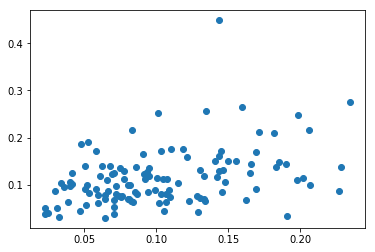

In [50]:
Show2dCorpora(corpus_tfidf)

### LSI

#### 确定 topics 数

In [ ]:
evaluate_coherence_values(models.LsiModel,dictionary=dictionary, corpus=corpus, texts=texts, start=1, limit=10, step=2, coherence='c_v')

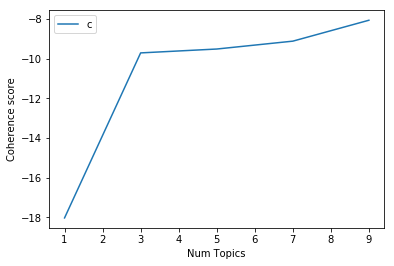

In [51]:
evaluate_coherence_values(models.LsiModel,dictionary=dictionary, corpus=corpus, texts=texts, start=1, limit=10, step=2, coherence='u_mass')

#### lsi 分析

In [52]:
# 转化为lsi模型, 可用作聚类或分类
lsi_model = models.LsiModel(corpus, id2word=dictionary, num_topics=3)
corpus_lsi = lsi_model[corpus]
list(corpus_lsi)

[[(0, -2.126872776680535), (1, 0.15532555184097202), (2, -1.0045189128501884)],
 [(0, -1.880496999728003), (1, 0.2000449450987565), (2, -0.32925024500877)],
 [(0, -3.4618029910045545), (1, 0.4672664309979741), (2, -1.461007560334423)],
 [(0, -7.234811186821637), (1, 1.360333209617436), (2, -5.545249822022745)],
 [(0, -3.018777773913761), (1, 0.44391801402646264), (2, -1.5941451452984952)],
 [(0, -3.5566818149034636), (1, 0.5396146025416477), (2, -1.6851370697894585)],
 [(0, -2.719770471049356), (1, 0.49374529899064135), (2, -1.6088099563062932)],
 [(0, -5.9711637511808995), (1, 0.7399874678961231), (2, -2.8209298292001894)],
 [(0, -4.6956241089001844), (1, 0.5384476856561153), (2, -1.3291107416171912)],
 [(0, -9.433869626540673), (1, 0.8706708424366939), (2, -4.035441374167979)],
 [(0, -3.5772251144777445),
  (1, 0.1258629961767742),
  (2, -0.04719943513204498)],
 [(0, -1.1725377510268125),
  (1, 0.13873267576704063),
  (2, -0.10798473397855822)],
 [(0, -3.8019034365226188), (1, 0.1642

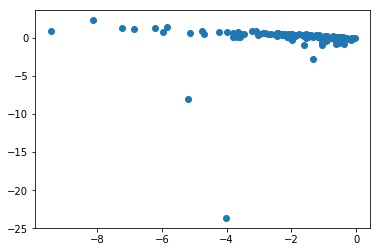

In [53]:
Show2dCorpora(corpus_lsi)

In [54]:
lsi_model.show_topics(num_words=5)

[(0, '-0.397*"中国" + -0.286*"月" + -0.243*"日" + -0.240*"5G" + -0.230*"美国"'),
 (1, '-0.894*"机器人" + -0.175*"智能" + -0.149*"包括" + -0.132*"工业" + 0.078*"5G"'),
 (2, '0.436*"5G" + 0.291*"设备" + 0.279*"印度" + 0.262*"华" + -0.188*"月"')]

In [55]:
nodes = list(corpus_lsi)
pprint(nodes[0:1])
lsi_model.print_topics(3) # 打印各topic的含义

[[(0, -2.126872776680535), (1, 0.15532555184097202), (2, -1.0045189128501884)]]


[(0,
  '-0.397*"中国" + -0.286*"月" + -0.243*"日" + -0.240*"5G" + -0.230*"美国" + -0.181*"印度" + -0.163*"设备" + -0.156*"中" + -0.153*"华" + -0.140*"机器人"'),
 (1,
  '-0.894*"机器人" + -0.175*"智能" + -0.149*"包括" + -0.132*"工业" + 0.078*"5G" + -0.075*"服务" + -0.075*"家用" + -0.075*"行业" + -0.074*"万台" + -0.071*"分为"'),
 (2,
  '0.436*"5G" + 0.291*"设备" + 0.279*"印度" + 0.262*"华" + -0.188*"月" + -0.179*"病毒" + 0.177*"网络" + 0.171*"华为" + -0.158*"传播" + -0.144*"疫情"')]

In [56]:
lsi_model.save('output/model_zh.lsi') # same for tfidf, lda, ...
lsi_model = models.LsiModel.load('output/model_zh.lsi')

### LDA 模型

#### 确定 topics 数

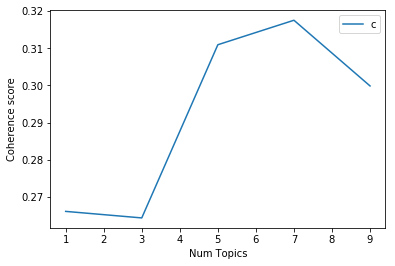

In [432]:
evaluate_coherence_values(models.LdaModel,dictionary=dictionary, corpus=corpus, texts=texts, start=1, limit=10, step=2, coherence='c_v')

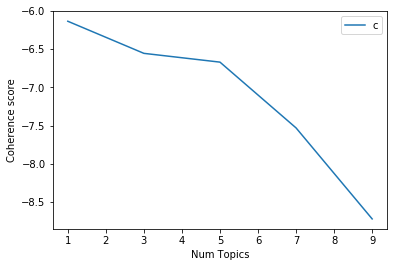

In [57]:
evaluate_coherence_values(models.LdaModel,dictionary=dictionary, corpus=corpus, texts=texts, start=1, limit=10, step=2, coherence='u_mass')

#### LDA 分析

In [58]:
lda_model = models.LdaModel(corpus, id2word=dictionary, iterations=50, num_topics=3)
corpus_lda = lda_model[corpus]
# list(corpus_lda)

x:[(0, 0.99072385)]
x:[(0, 0.9913834)]
x:[(0, 0.994219)]
x:[(1, 0.9876563)]
x:[(1, 0.9859755)]
x:[(0, 0.9927842)]
x:[(1, 0.99342304)]
x:[(2, 0.99352854)]
x:[(2, 0.99068016)]
x:[(1, 0.9929505)]
x:[(0, 0.98845774)]
x:[(0, 0.987287)]
x:[(0, 0.99193025)]
x:[(1, 0.992783)]
x:[(1, 0.9922419)]
x:[(2, 0.9861824)]
x:[(1, 0.98304844)]
x:[(2, 0.99058867)]
x:[(1, 0.9820698)]
x:[(1, 0.9917714)]
x:[(2, 0.9860328)]
x:[(2, 0.98632103)]
x:[(2, 0.99242985)]
x:[(1, 0.9898931)]
x:[(2, 0.9828032)]
x:[(0, 0.98732007)]
x:[(0, 0.9890797)]
x:[(0, 0.99055004)]
x:[(0, 0.9899117)]
x:[(1, 0.98686385)]
x:[(1, 0.9858567)]
x:[(1, 0.9812493)]
x:[(1, 0.98382825)]
x:[(2, 0.9888815)]
x:[(1, 0.9949595)]
x:[(0, 0.9838306)]
x:[(0, 0.98105395)]
x:[(0, 0.9838573)]
x:[(0, 0.98555416)]
x:[(0, 0.9909269)]
x:[(1, 0.987093)]
x:[(1, 0.98967016)]
x:[(0, 0.99167955)]
x:[(2, 0.9864839)]
x:[(0, 0.99014467)]
x:[(0, 0.9888251)]
x:[(2, 0.9878087)]


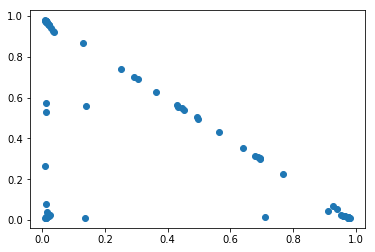

In [59]:
Show2dCorpora(corpus_lda)

In [60]:
lda_model.show_topics(num_words=10)

[(0,
  '0.012*"中国" + 0.010*"印度" + 0.009*"5G" + 0.008*"月" + 0.008*"华" + 0.006*"美国" + 0.006*"设备" + 0.006*"中" + 0.006*"华为" + 0.005*"病毒"'),
 (1,
  '0.011*"5G" + 0.008*"中国" + 0.008*"日" + 0.007*"月" + 0.007*"机器人" + 0.006*"华为" + 0.006*"华" + 0.005*"中" + 0.005*"美国" + 0.005*"设备"'),
 (2,
  '0.011*"中国" + 0.006*"美国" + 0.006*"印度" + 0.005*"设备" + 0.005*"华" + 0.005*"月" + 0.004*"说" + 0.004*"日" + 0.004*"包括" + 0.004*"中"')]

In [61]:
# nodes = list(corpus_lda)
# pprint(nodes)
lda_model.print_topics(3) # 打印各topic的含义

[(0,
  '0.012*"中国" + 0.010*"印度" + 0.009*"5G" + 0.008*"月" + 0.008*"华" + 0.006*"美国" + 0.006*"设备" + 0.006*"中" + 0.006*"华为" + 0.005*"病毒"'),
 (1,
  '0.011*"5G" + 0.008*"中国" + 0.008*"日" + 0.007*"月" + 0.007*"机器人" + 0.006*"华为" + 0.006*"华" + 0.005*"中" + 0.005*"美国" + 0.005*"设备"'),
 (2,
  '0.011*"中国" + 0.006*"美国" + 0.006*"印度" + 0.005*"设备" + 0.005*"华" + 0.005*"月" + 0.004*"说" + 0.004*"日" + 0.004*"包括" + 0.004*"中"')]

In [62]:
lda_model.save('output/model_zh.lda') # same for tfidf, lda, ...
lda_model = models.LdaModel.load('output/model_zh.lda')

#### 预测词汇的主题归属

In [ ]:
#根据主题模型运行出来的结果，序号为0的暂定为“水果”，序号为1的暂定为“公司”，用来测试几个词
topic_list = ['水果','公司']
[(topic_list[i[0]],i[1]) for i in lda_model.get_term_topics('落叶乔木')]

In [224]:
[(topic_list[i[0]],i[1]) for i in lda_model.get_term_topics('智能手机')]

[('水果', 0.014365447), ('公司', 0.045314416)]

#### 预测文档的主题归属

get_document_topics是一个用于推断文档主题归属的函数/方法，在这里，假设一个文档可能同时包含若干个主题，但在每个主题上的概率不一样，文档最有可能从属于概率最大的主题。

此外，该函数也可以让我们了解某个文档中的某个词汇在主题上的分布情况

In [257]:
bow_fruit = ['苹果','树上','落叶乔木','互联网']
bow_company = ['苹果','电脑','乔布斯']

In [260]:
bow = lda_model.id2word.doc2bow(bow_fruit) # 现将文档转换为词袋表示
doc_topics, word_topics, phi_values = lda_model.get_document_topics(bow, per_word_topics=True)
'''
    doc_topics:  0 的 值比较大，表示 文档 bow_fruit 偏向于 水果 
    word_topics: 
        (1, [0, 1]):  表示 "苹果" 偏向于 0 ，也就是 偏向于 水果
        (3, [0, 1]):  表示 "苹果" 偏向于 0 ，也就是 偏向于 水果
        (6, [0, 1]):  表示 "苹果" 偏向于 0 ，也就是 偏向于 水果
        (13, [1, 0]): 表示 "苹果" 偏向于 1 ，也就是 偏向于 计算机
    phi_values： 是文档中某个词汇从属于某个主题的概率值
        (1, [(0, 0.6987403), (1, 0.30125546)]) ：
        (3, [(0, 0.6467843), (1, 0.35321417)]) ：
        (6, [(0, 0.6352302), (1, 0.3647655)])  ：
        (13, [(0, 0.40299222), (1, 0.597003)]) ：

'''
doc_topics, word_topics, phi_values

([(0, 0.5757472), (1, 0.42425284)],
 [(1, [0, 1]), (3, [0, 1]), (6, [0, 1]), (13, [1, 0])],
 [(1, [(0, 0.6978617), (1, 0.30213407)]),
  (3, [(0, 0.6458309), (1, 0.35416755)]),
  (6, [(0, 0.6342633), (1, 0.36573237)]),
  (13, [(0, 0.40198928), (1, 0.598006)])])

In [261]:
bow = lda_model.id2word.doc2bow(bow_company) # 现将文档转换为词袋表示
doc_topics, word_topics, phi_values = lda_model.get_document_topics(bow, per_word_topics=True)
doc_topics, word_topics, phi_values

([(0, 0.1572369), (1, 0.84276307)],
 [(3, [1, 0]), (15, [1, 0]), (19, [1, 0])],
 [(3, [(0, 0.09331771), (1, 0.9066806)]),
  (15, [(0, 0.02068906), (1, 0.9793089)]),
  (19, [(0, 0.014593847), (1, 0.9854043)])])

In [262]:
all_topics = lda_model.get_document_topics(corpus, per_word_topics=True)
cnt = 0
for doc_topics, word_topics, phi_values in all_topics:
    print('新文档:{} \n'.format(cnt),texts[cnt])
    doc_topics = [(topic_list[i[0]],i[1]) for i in doc_topics]
    word_topics = [(dictionary.id2token [i[0]],i[1]) for i in word_topics]
    phi_values = [(dictionary.id2token [i[0]],i[1]) for i in phi_values ]
    print('文档主题:', doc_topics)
    print('词汇主题:', word_topics)
    print('Phi值:', phi_values)
    print(" ")
    print('-------------- \n')
    cnt+=1

新文档:0 
 ['苹果', '叶子', '椭圆形', '树上']
文档主题: [('水果', 0.20404471), ('公司', 0.79595524)]
词汇主题: [('叶子', [1, 0]), ('树上', [1, 0]), ('椭圆形', [1, 0]), ('苹果', [1, 0])]
Phi值: [('叶子', [(0, 0.06913688), (1, 0.9308596)]), ('树上', [(0, 0.20862806), (1, 0.7913669)]), ('椭圆形', [(0, 0.06940393), (1, 0.9305896)]), ('苹果', [(0, 0.17227446), (1, 0.827724)])]
 
-------------- 

新文档:1 
 ['植物', '叶子', '绿色', '落叶乔木']
文档主题: [('水果', 0.16026261), ('公司', 0.8397374)]
词汇主题: [('叶子', [1, 0]), ('植物', [1, 0]), ('绿色', [1, 0]), ('落叶乔木', [1, 0])]
Phi值: [('叶子', [(0, 0.044015028), (1, 0.9559816)]), ('植物', [(0, 0.12023423), (1, 0.87976086)]), ('绿色', [(0, 0.027091045), (1, 0.9729035)]), ('落叶乔木', [(0, 0.10929245), (1, 0.8907028)])]
 
-------------- 

新文档:2 
 ['水果', '苹果', '红彤彤', '味道']
文档主题: [('水果', 0.8840432), ('公司', 0.115956806)]
词汇主题: [('苹果', [0, 1]), ('味道', [0, 1]), ('水果', [0]), ('红彤彤', [0, 1])]
Phi值: [('苹果', [(0, 0.9612174), (1, 0.038781133)]), ('味道', [(0, 0.98415804), (1, 0.015836788)]), ('水果', [(0, 0.9914247)]), ('红彤彤', [(0, 0.98356

In [233]:
bow

[(3, 1), (15, 1), (19, 1)]

## 相似度计算

这一部分主要负责计算文档间的相似度。与向量的相似度计算方式一样，采用余弦方法计算得到。一般来讲，使用lsi模型得到的向量进行计算效果比较好。

### 预操作

In [69]:
test_documents = [
    "从参与主体来看，中国人工智能企业的知识生产能力亟待提升。科研机构和大学是目前中国人工智能知识生产的主要力量。相比国外领先企业，中国企业作为一个群体的技术表现还比较逊色，在人工智能专利申请上落后于国内高校和科研院所。即使是被公认为人工智能巨头的百度、阿里巴巴、腾讯(BAT) 等企业，在人才、论文和专利方面也还没有突出的表现，而它们的美国对手 IBM、微软、谷歌等企业在每项指标的全球企业排名中均名列前茅。"
]
test_text = data_process(test_documents)
test_bow = dictionary.doc2bow(test_text[0])

### 利用 TF-idf 、 LSI、 LDA 计算相似度

In [70]:
model_list = [tfidf_model,lsi_model,lda_model]
model_name = ['tfidf','lsi','lda']
corpus_list = [corpus_tfidf,corpus_lsi,corpus_lda]
test_res_dict = {}
for i in range(len(model_name)):
    test = model_list[i][test_bow]
    test_corpus_simi_matrix = similarities.MatrixSimilarity(corpus_list[i])
    test_simi = test_corpus_simi_matrix[test]
    test_res_dict[model_name[i]] = list(enumerate(test_simi))
#     print(f"{model_name[i]}:{test_res_dict[model_name[i]]}")

test_res_list = [test_res_dict['tfidf'],test_res_dict['lsi'],test_res_dict['lda']]

In [71]:
score_list = []
for i in range(len(test_res_list[0])):
    score = (test_res_list[0][i][1]+test_res_list[1][i][1]+test_res_list[2][i][1])/3
    score_list.append((i,score))
    print(f"{test_res_list[0][i]}\t{test_res_list[1][i]}\t{test_res_list[2][i]}\t{score}")

(0, 0.015491906)	(0, 0.89549166)	(0, 0.99978375)	0.6369224389394125
(1, 0.0031413573)	(1, 0.97749114)	(1, 0.788953)	0.5898618300755819
(2, 0.023075636)	(2, 0.908677)	(2, 0.788953)	0.5735685427983602
(3, 0.0060661943)	(3, 0.7759974)	(3, 0.788953)	0.5236721833546957
(4, 0.015935928)	(4, 0.8700564)	(4, 0.6142128)	0.5000683466593424
(5, 0.052671283)	(5, 0.8891969)	(5, 0.9742775)	0.6387152274449667
(6, 0.0)	(6, 0.8430921)	(6, 0.6142128)	0.48576831817626953
(7, 0.014266154)	(7, 0.89221066)	(7, 0.788953)	0.5651432673136393
(8, 0.019542523)	(8, 0.95261395)	(8, 0.6142128)	0.528789758682251
(9, 0.036894448)	(9, 0.9100927)	(9, 0.01719754)	0.3213949004809062
(10, 0.055006135)	(10, 0.9991979)	(10, 0.01719754)	0.35713382562001544
(11, 0.013508805)	(11, 0.9882478)	(11, 0.7965741)	0.5994435946146647
(12, 0.053965926)	(12, 0.9866135)	(12, 0.6142128)	0.5515974362691244
(13, 0.0060133245)	(13, 0.77779794)	(13, 0.87346613)	0.5524257818857828
(14, 0.0)	(14, 0.6238331)	(14, 0.788953)	0.47092870871225995
(15

In [72]:
# 获取列表的第二个元素
def takeSecond(elem):
    return elem[1]
score_list.sort(key=takeSecond,reverse=True)

In [73]:
score_list

[(49, 0.6678330103556315),
 (5, 0.6387152274449667),
 (110, 0.6382366021474203),
 (0, 0.6369224389394125),
 (72, 0.6202784776687622),
 (53, 0.6141548951466879),
 (44, 0.6080721219380697),
 (11, 0.5994435946146647),
 (66, 0.5967239538828532),
 (18, 0.5953205823898315),
 (1, 0.5898618300755819),
 (48, 0.5889864365259806),
 (93, 0.5846197605133057),
 (89, 0.5836240450541178),
 (47, 0.5799827178319296),
 (2, 0.5735685427983602),
 (46, 0.5721267859141032),
 (32, 0.5712114175160726),
 (83, 0.566780686378479),
 (7, 0.5651432673136393),
 (74, 0.5624552567799886),
 (113, 0.5590030352274576),
 (41, 0.5575030644734701),
 (13, 0.5524257818857828),
 (12, 0.5515974362691244),
 (68, 0.5432263612747192),
 (45, 0.5402131080627441),
 (86, 0.5391183296839396),
 (84, 0.5346222718556722),
 (116, 0.5334509213765463),
 (8, 0.528789758682251),
 (3, 0.5236721833546957),
 (19, 0.5234585205713908),
 (76, 0.5220215320587158),
 (16, 0.519207755724589),
 (77, 0.5187860329945883),
 (55, 0.5145105123519897),
 (82, 0.